# Import packages

import useful packages for experiments

In [1]:
import os
import argparse
import logging

import torch
from torch.optim.lr_scheduler import StepLR
import torchtext

from trainer.supervised_trainer import SupervisedTrainer
from models.encoderRNN import EncoderRNN
from models.decoderRNN import DecoderRNN
from models.seq2seq import Seq2seq
from loss.loss import Perplexity
from optim.optim import Optimizer
from dataset import fields
from evaluator.predictor import Predictor

import matplotlib.pyplot as plt

/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))
/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


# Log format

In [2]:
log_level = 'info'
LOG_FORMAT = '%(asctime)s %(levelname)-6s %(message)s'
logging.basicConfig(format=LOG_FORMAT, level=getattr(logging, log_level.upper()))

# Pretrain - Data load

In [3]:
pretrain_train_path = "data/grammar_data_N50_train.txt"
pretrain_dev_path = "data/grammar_data_N50_test.txt"

# Train - Data load

In [4]:
train_path = "data/grammar_data_N100_train.txt"
dev_path = "data/grammar_data_N100_test.txt"

# Pretrain - Prepare dataset

In [5]:
pretrain_src = fields.SourceField()
pretrain_tgt = fields.TargetField()
max_len = 102
def len_filter(example):
    return len(example.src) <= max_len and len(example.tgt) <= max_len
pretrain_train = torchtext.data.TabularDataset(
    path=pretrain_train_path, format='tsv',
    fields=[('src', pretrain_src), ('tgt', pretrain_tgt)],
    filter_pred=len_filter
)
pretrain_dev = torchtext.data.TabularDataset(
    path=pretrain_dev_path, format='tsv',
    fields=[('src', pretrain_src), ('tgt', pretrain_tgt)],
    filter_pred=len_filter
)
pretrain_src.build_vocab(pretrain_train)
pretrain_tgt.build_vocab(pretrain_train)
pretrain_input_vocab = pretrain_src.vocab
pretrain_output_vocab = pretrain_tgt.vocab

# Train - Prepare dataset

In [6]:
src = fields.SourceField()
tgt = fields.TargetField()
max_len = 102
def len_filter(example):
    return len(example.src) <= max_len and len(example.tgt) <= max_len
train = torchtext.data.TabularDataset(
    path=train_path, format='tsv',
    fields=[('src', src), ('tgt', tgt)],
    filter_pred=len_filter
)
dev = torchtext.data.TabularDataset(
    path=dev_path, format='tsv',
    fields=[('src', src), ('tgt', tgt)],
    filter_pred=len_filter
)
src.build_vocab(train)
tgt.build_vocab(train)
input_vocab = src.vocab
output_vocab = tgt.vocab

# Pretrain - Prepare loss

In [7]:
pretrain_weight = torch.ones(len(pretrain_tgt.vocab))
pretrain_pad = pretrain_tgt.vocab.stoi[pretrain_tgt.pad_token]
pretrain_loss = Perplexity(pretrain_weight, pretrain_pad)
if torch.cuda.is_available():
    pretrain_loss.cuda()

/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


# Train - Prepare loss

In [8]:
weight = torch.ones(len(tgt.vocab))
pad = tgt.vocab.stoi[tgt.pad_token]
loss = Perplexity(weight, pad)
if torch.cuda.is_available():
    loss.cuda()

# Variable definition

In [9]:
seq2seq = None
optimizer = "Adam"

hidden_sizes = list(range(50, 51, 4))
print(hidden_sizes)
error_rate = []
accuracy = []
losses = []

[50]


# Initialize model

2019-01-28 13:41:23,352 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


Hidden size is 50
6
49
6
49
pretrain..


2019-01-28 13:43:24,036 INFO   Finished epoch 1: Train loss: 7.2360, Dev loss: 2.7288, Accuracy(Character): 0.5807, Accuracy(Word): 0.0000
2019-01-28 13:45:24,479 INFO   Finished epoch 2: Train loss: 2.0883, Dev loss: 2.1155, Accuracy(Character): 0.6935, Accuracy(Word): 0.0000
2019-01-28 13:45:24,566 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


train..


2019-01-28 13:49:05,874 INFO   Finished epoch 1: Train loss: 98.8702, Dev loss: 3.9972, Accuracy(Character): 0.4786, Accuracy(Word): 0.0000
2019-01-28 13:52:43,523 INFO   Finished epoch 2: Train loss: 2.8946, Dev loss: 3.6773, Accuracy(Character): 0.5034, Accuracy(Word): 0.0000


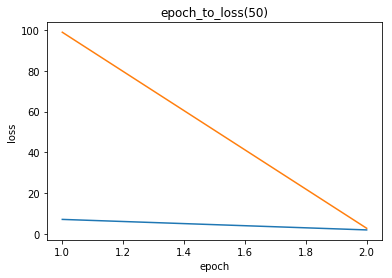

In [11]:
for i in hidden_sizes:
    print("Hidden size is %d" % i)
    hidden_size = i
    bidirectional = True
    print(len(pretrain_src.vocab))
    print(len(pretrain_tgt.vocab))
    print(len(src.vocab))
    print(len(tgt.vocab))
    pretrain_encoder = EncoderRNN(len(pretrain_src.vocab), max_len, hidden_size,
                        bidirectional=bidirectional, variable_lengths=True)
    pretrain_decoder = DecoderRNN(len(pretrain_tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                        dropout_p=0.2, use_attention=False, bidirectional=bidirectional,
                        eos_id=pretrain_tgt.eos_id, sos_id=pretrain_tgt.sos_id)
    pretrain_seq2seq = Seq2seq(pretrain_encoder, pretrain_decoder)
    if torch.cuda.is_available():
        pretrain_seq2seq.cuda()

    for param in pretrain_seq2seq.parameters():
        param.data.uniform_(-0.08, 0.08)

    # train
    pretrain_t = SupervisedTrainer(loss=pretrain_loss, batch_size=32,
                                checkpoint_every=50,
                                print_every=100, hidden_size=hidden_size)
    print("pretrain..")

    pretrain_seq2seq, ave_loss, character_accuracy = pretrain_t.train(pretrain_seq2seq, pretrain_train,
                                                                num_epochs=2, dev_data=pretrain_dev,
                                                                optimizer=optimizer,
                                                                teacher_forcing_ratio=0.5)
    
    encoder = EncoderRNN(len(src.vocab), max_len, hidden_size,
                        bidirectional=bidirectional, variable_lengths=True)
    decoder = DecoderRNN(len(tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                        dropout_p=0.2, use_attention=False, bidirectional=bidirectional,
                        eos_id=tgt.eos_id, sos_id=tgt.sos_id)
    seq2seq = Seq2seq(encoder, decoder)
    if torch.cuda.is_available():
        seq2seq.cuda()

    for param in seq2seq.parameters():
        param.data.uniform_(-0.08, 0.08)
        
    seq2seq.load_state_dict(pretrain_seq2seq.state_dict())
    seq2seq.train()

    # train
    t = SupervisedTrainer(loss=loss, batch_size=32,
                        checkpoint_every=50,
                        print_every=100, hidden_size=hidden_size)
    
    print("train..")
    seq2seq, ave_loss, character_accuracy = t.train(seq2seq, train,
                                                    num_epochs=2, dev_data=dev,
                                                    optimizer=optimizer,
                                                    teacher_forcing_ratio=0.5)

    losses.append(ave_loss/100)
    error_rate.append(1 - character_accuracy)
    accuracy.append(character_accuracy)

In [13]:
torch.save(seq2seq.state_dict(), 'log/model_save.pth')